# The Hartree equations for two electrons in one dimension

### This script solves the Hartree equations for two interacting electrons in  a one-dimensional infinite potential well. The strength of the electron-electron interaction can by tuned by the parameter 'gamma'.

In [1]:
%matplotlib widget

In [2]:
import numpy as np
from scipy import linalg as LA
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [3]:
from ase.build import bulk

In [4]:
from gpaw import GPAW

In [5]:
hbar = 1   # Plancks constant
m = 1      # electron mass
L = 1  # Length of potential well
xmin=-0.1  # minimum x-coordinate
xmax=L+0.1 # maximum x-coordinate
Vinf = 1e9 # value of (external) potential outside the well

gamma = 1e5  # Scaling of electron-electron interaction [ we use 1/|x-x'| --> V_delta*delta(x-x') ]

mixer = 0.5
dx = 0.01 # discretization in x

In [6]:
x=np.arange(xmin,xmax,dx)
nx = len(x)
vext=0*x  # External potential
n1=np.where(x<0)
n2=np.where(x>L)
vext[n1]=Vinf
vext[n2]=Vinf
Vext=np.diag(vext) #External potential as a matrix (operator) # makes the value into diagonal matrix.
#plt.plot(x, vext)
# 

In [7]:
T=np.eye(nx) # Kinetic energy operator
# print(T)
for i in range(nx-1):
    T[i,i+1]=-0.5
    T[i+1,i]=-0.5
T = T/(dx**2)*hbar**2/m
# print(T)

In [8]:
H = T + Vext   # Non-interacting Hamiltonian as matrix
# print(H)

In [9]:
En,Psi0 =LA.eigh(H,eigvals=(0,8))
print(En)
print(En*27.21)

[  4.83717601  19.34402476  43.50651174  77.3012611  120.6955788
 173.64748364 236.10574812 308.00994797 389.29052046]
[  131.61955929   526.35091383  1183.81218432  2103.36731456
  3284.12669924  4724.94802983  6424.43740626  8380.95068433
 10592.59506165]


<ipython-input-9-f52740afe7c6>:1: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  En,Psi0 =LA.eigh(H,eigvals=(0,8))


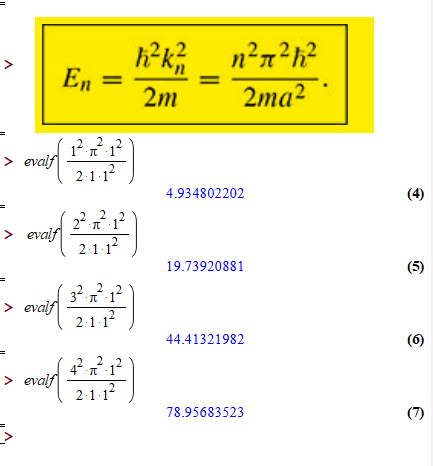
So we see there is a really good aggreement

In [10]:
#plt.figure()
#plt.plot(x, Psi0[:,5])
#plt.plot(x, Psi0[:,0])

#for i in range(3):
#plt.plot(x, Psi0[:,i])

In [11]:
En # energies of the first 8 excitations
# The number is given in hartrees obviously

array([  4.83717601,  19.34402476,  43.50651174,  77.3012611 ,
       120.6955788 , 173.64748364, 236.10574812, 308.00994797,
       389.29052046])

### Start of Hartree part

In [12]:
count = 1
psi_diff = 100
tol = 1e-3  # convergence criterion for the difference in wave functions

In [13]:
gamma=1e6 # coupling strength basically.

In [14]:
psi1 = Psi0[:,0]
psi2 = Psi0[:,1]

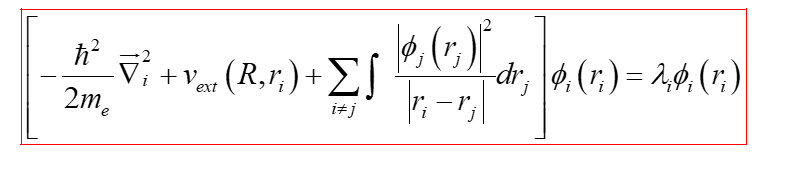

Effective potential from other wave function

<ipython-input-15-25733c81de85>:19: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
<ipython-input-15-25733c81de85>:20: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e2,Psi2 = LA.eigh(H2,eigvals=(0,5))


converged after 161 steps!


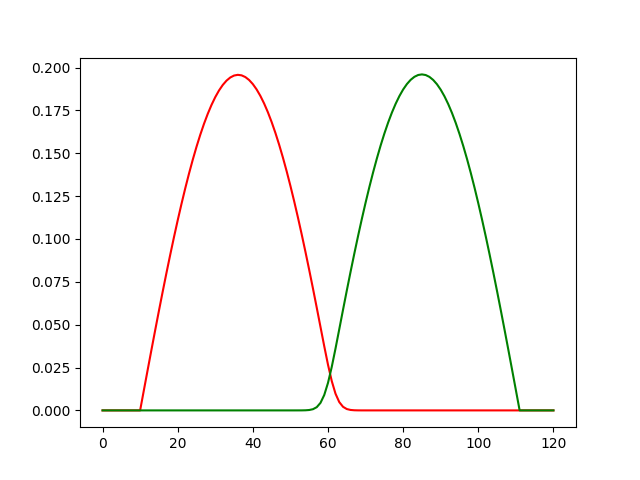

In [15]:
count=1
psi_diff = 100
tol= 1e-3
while (count<1000) and (psi_diff>tol):
    n1 = abs(psi1**2)
    n2 = abs(psi2**2) #probability function.

    # Setup effective potential for electron '1' and '2'
    v1 = n2*gamma     
    V1 = np.diag(v1) #effective potential is the other function

    v2 = n1*gamma  
    V2 = np.diag(v2)

    # New hamiltonians for '1' and '2' # makes new hamiltonians
    H1 = T+Vext+V1
    H2 = T+Vext+V2

    e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
    e2,Psi2 = LA.eigh(H2,eigvals=(0,5))
    e1=e1[0]
    psi1_new=Psi1[:,0] # taking ground state.
    e2=e2[0]
    psi2_new=Psi2[:,0]

    psi_diff1 = sum(abs(abs(psi1)-abs(psi1_new))) # checing convergence by basically that it does not change to drastically
    psi_diff2 = sum(abs(abs(psi2)-abs(psi2_new)))
    psi_diff = max(psi_diff1,psi_diff2)
    count = count+1    

    psi1 = psi1*(1-mixer) + psi1_new*mixer # makes new wavefunctions as a mix of the ol plus the new.
    psi2 = psi2*(1-mixer) + psi2_new*mixer
    psi1 = psi1/norm(psi1) # normalizing
    psi2 = psi2/norm(psi2)
print(f'converged after {count} steps!')
plt.figure()
plt.plot(psi1,'r',psi2,'g')

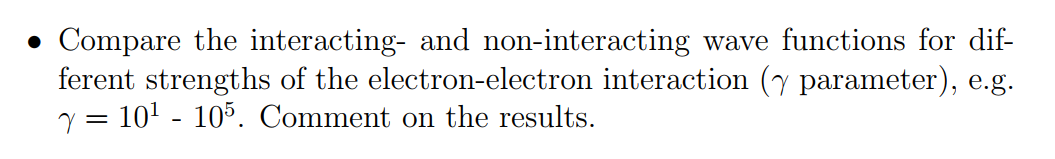

<ipython-input-16-e94f87b7f879>:41: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  En,Psi0 =LA.eigh(H,eigvals=(0,8))


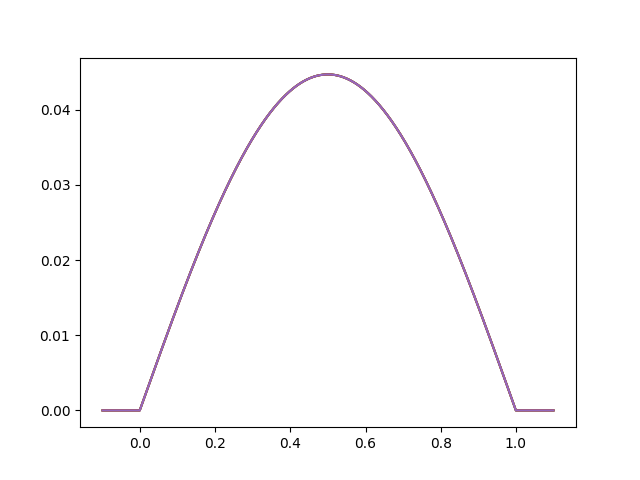

In [16]:
#Here we just compare on the different interaction strengths with noninteracting.

gamma_vec = [1e1, 1e2, 1e3, 1e4, 1e5]
plt.figure()
for gamma in gamma_vec:
    hbar = 1   # Plancks constant
    m = 1      # electron mass
    L = 1      # Length of potential well
    xmin=-0.1  # minimum x-coordinate
    xmax=L+0.1 # maximum x-coordinate
    Vinf = 1e9 # value of (external) potential outside the well

    #gamma = 1e5  # Scaling of electron-electron interaction [ we use 1/|x-x'| --> V_delta*delta(x-x') ]

    mixer = 0.5
    dx = 0.001 # discretization in x


    x=np.arange(xmin,xmax,dx)
    nx = len(x)
    vext=0*x  # External potential
    n1=np.where(x<0)
    n2=np.where(x>L)
    vext[n1]=Vinf
    vext[n2]=Vinf
    Vext=np.diag(vext) #External potential as a matrix (operator) # makes the value into diagonal matrix.
    #plt.plot(x, vext)
    # 

    T=np.eye(nx) # Kinetic energy operator
    # print(T)
    for i in range(nx-1):
        T[i,i+1]=-0.5
        T[i+1,i]=-0.5
    T = T/(dx**2)*hbar**2/m
    # print(T)

    H = T + Vext   # Non-interacting Hamiltonian as matrix
    # print(H)

    En,Psi0 =LA.eigh(H,eigvals=(0,8))

    count = 1
    psi_diff = 100
    tol = 1e-3  # convergence criterion for the difference in wave functions
    plt.plot(x, Psi0[:,0])
    


In [17]:
#From the above figure we see absolutely no change in the noninteraction wave function, which is no surprise.

<ipython-input-18-98a87e67b403>:44: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  En,Psi0 =LA.eigh(H,eigvals=(0,8))
<ipython-input-18-98a87e67b403>:72: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
<ipython-input-18-98a87e67b403>:73: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e2,Psi2 = LA.eigh(H2,eigvals=(0,5))


converged after 28 steps!
converged after 28 steps!
converged after 32 steps!
converged after 45 steps!
converged after 116 steps!


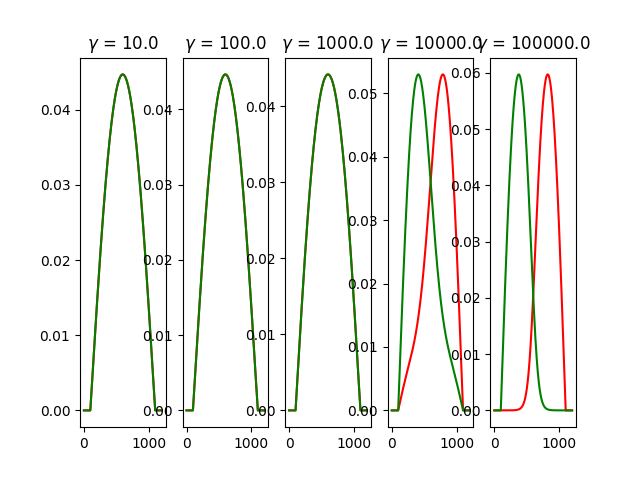

In [18]:
#interacting
#Here we just compare on the different interaction strengths with noninteracting.

gamma_vec = [1e1, 1e2, 1e3, 1e4, 1e5]
plt.figure()
fig_num = 0
for gamma in gamma_vec:
    fig_num+=1
    hbar = 1   # Plancks constant
    m = 1      # electron mass
    L = 1      # Length of potential well
    xmin=-0.1  # minimum x-coordinate
    xmax=L+0.1 # maximum x-coordinate
    Vinf = 1e9 # value of (external) potential outside the well

    #gamma = 1e5  # Scaling of electron-electron interaction [ we use 1/|x-x'| --> V_delta*delta(x-x') ]

    mixer = 0.5
    dx = 0.001 # discretization in x


    x=np.arange(xmin,xmax,dx)
    nx = len(x)
    vext=0*x  # External potential
    n1=np.where(x<0)
    n2=np.where(x>L)
    vext[n1]=Vinf
    vext[n2]=Vinf
    Vext=np.diag(vext) #External potential as a matrix (operator) # makes the value into diagonal matrix.
    #plt.plot(x, vext)
    # 

    T=np.eye(nx) # Kinetic energy operator
    # print(T)
    for i in range(nx-1):
        T[i,i+1]=-0.5
        T[i+1,i]=-0.5
    T = T/(dx**2)*hbar**2/m
    # print(T)

    H = T + Vext   # Non-interacting Hamiltonian as matrix
    # print(H)

    En,Psi0 =LA.eigh(H,eigvals=(0,8))

    count = 1
    psi_diff = 100
    tol = 1e-3  # convergence criterion for the difference in wave functions
    #plt.plot(x, Psi0[:,0])
    
    psi1 = Psi0[:,0]
    psi2 = Psi0[:,1]

    count=1
    psi_diff = 100
    tol= 1e-6
    while (count<1000) and (psi_diff>tol):
        n1 = abs(psi1**2)
        n2 = abs(psi2**2) #probability function.

        # Setup effective potential for electron '1' and '2'
        v1 = n2*gamma     
        V1 = np.diag(v1) #effective potential is the other function

        v2 = n1*gamma  
        V2 = np.diag(v2)

        # New hamiltonians for '1' and '2' # makes new hamiltonians
        H1 = T+Vext+V1
        H2 = T+Vext+V2

        e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
        e2,Psi2 = LA.eigh(H2,eigvals=(0,5))
        e1=e1[0]
        psi1_new=Psi1[:,0] # taking ground state.
        e2=e2[0]
        psi2_new=Psi2[:,0]

        psi_diff1 = sum(abs(abs(psi1)-abs(psi1_new))) # checing convergence by basically that it does not change to drastically
        psi_diff2 = sum(abs(abs(psi2)-abs(psi2_new)))
        psi_diff = max(psi_diff1,psi_diff2)
        count = count+1    

        psi1 = psi1*(1-mixer) + psi1_new*mixer # makes new wavefunctions as a mix of the ol plus the new.
        psi2 = psi2*(1-mixer) + psi2_new*mixer
        psi1 = psi1/norm(psi1) # normalizing
        psi2 = psi2/norm(psi2)
    print(f'converged after {count} steps!')
    plt.subplot(1, 5, fig_num)
    plt.plot(psi1,'r',psi2,'g')
    plt.title(f'$\gamma$ = {gamma}')


In [19]:
#The pertubation should at least be 1000 or less for the approximation to be good we also see that strong interaction really makes the electrons repulse, obeying the coulumb repulsion principle.

lets call j = 2 and i = 1

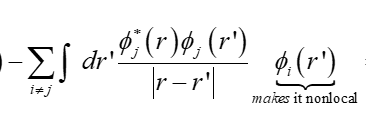



<ipython-input-20-c39786705258>:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
<ipython-input-20-c39786705258>:31: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e2,Psi2 = LA.eigh(H2,eigvals=(0,5))


converged after 31 steps!


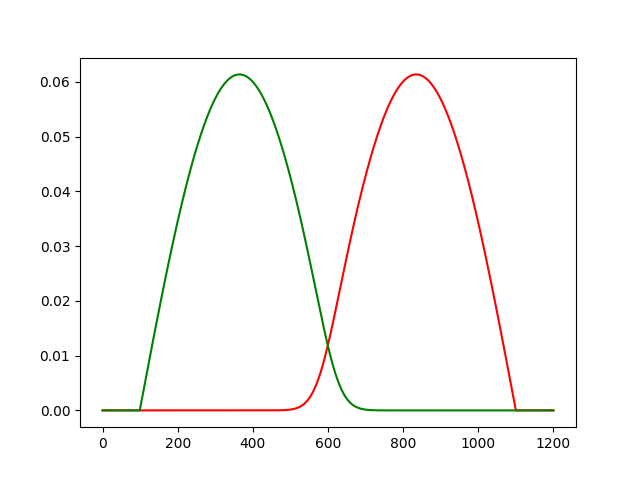

In [20]:
count=1
psi_diff = 100
tol= 1e-6
gamma = 1e6
while (count<1000) and (psi_diff>tol):
    n1 = abs(psi1**2)
    n2 = abs(psi2**2) #probability function.
    n12 = psi1*psi2*psi1
    n21 = psi2*psi1*psi2


    # Setup effective potential for electron '1' and '2'
    v1 = n2*gamma     
    V1 = np.diag(v1) #effective potential is the other function


    v2 = n1*gamma  
    V2 = np.diag(v2)

    #interaction from hartree fock equations
    v12 = n12*gamma
    V12 = np.diag(v12)
    v21 = n21*gamma
    V21 = np.diag(v21)

    # New hamiltonians for '1' and '2' # makes new hamiltonians
    H1 = T+Vext+V1 - V12
    H2 = T+Vext+V2 - V21

    e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
    e2,Psi2 = LA.eigh(H2,eigvals=(0,5))
    e1=e1[0]
    psi1_new=Psi1[:,0] # taking ground state.
    e2=e2[0]
    psi2_new=Psi2[:,0]

    psi_diff1 = sum(abs(abs(psi1)-abs(psi1_new))) # checing convergence by basically that it does not change to drastically
    psi_diff2 = sum(abs(abs(psi2)-abs(psi2_new)))
    psi_diff = max(psi_diff1,psi_diff2)
    count = count+1    

    psi1 = psi1*(1-mixer) + psi1_new*mixer # makes new wavefunctions as a mix of the ol plus the new.
    psi2 = psi2*(1-mixer) + psi2_new*mixer
    psi1 = psi1/norm(psi1) # normalizing
    psi2 = psi2/norm(psi2)
print(f'converged after {count} steps!')
plt.figure()
plt.plot(psi1,'r',psi2,'g')

<ipython-input-21-73c5e827f7da>:44: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  En,Psi0 =LA.eigh(H,eigvals=(0,8))
<ipython-input-21-73c5e827f7da>:81: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
<ipython-input-21-73c5e827f7da>:82: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e2,Psi2 = LA.eigh(H2,eigvals=(0,5))


converged after 1000 steps!


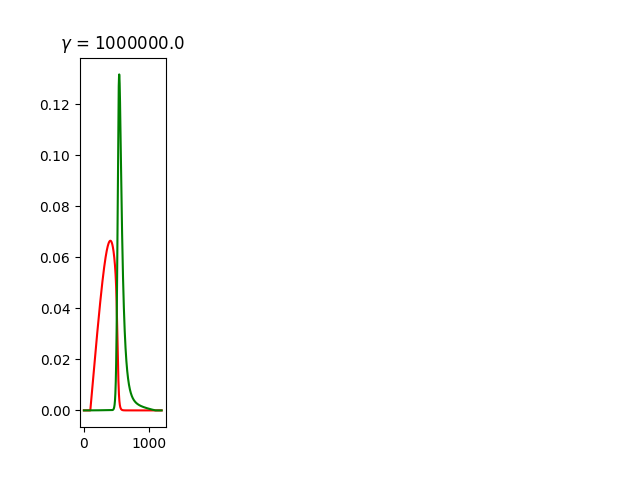

In [21]:
#interacting
#Here we just compare on the different interaction strengths with noninteracting.

gamma_vec = [1e6]
plt.figure()
fig_num = 0
for gamma in gamma_vec:
    fig_num+=1
    hbar = 1   # Plancks constant
    m = 1      # electron mass
    L = 1      # Length of potential well
    xmin=-0.1  # minimum x-coordinate
    xmax=L+0.1 # maximum x-coordinate
    Vinf = 1e9 # value of (external) potential outside the well

    #gamma = 1e5  # Scaling of electron-electron interaction [ we use 1/|x-x'| --> V_delta*delta(x-x') ]

    mixer = 0.5
    dx = 0.001 # discretization in x


    x=np.arange(xmin,xmax,dx)
    nx = len(x)
    vext=0*x  # External potential
    n1=np.where(x<0)
    n2=np.where(x>L)
    vext[n1]=Vinf
    vext[n2]=Vinf
    Vext=np.diag(vext) #External potential as a matrix (operator) # makes the value into diagonal matrix.
    #plt.plot(x, vext)
    # 

    T=np.eye(nx) # Kinetic energy operator
    # print(T)
    for i in range(nx-1):
        T[i,i+1]=-0.5
        T[i+1,i]=-0.5
    T = T/(dx**2)*hbar**2/m
    # print(T)

    H = T + Vext   # Non-interacting Hamiltonian as matrix
    # print(H)

    En,Psi0 =LA.eigh(H,eigvals=(0,8))

    count = 1
    psi_diff = 100
    tol = 1e-3  # convergence criterion for the difference in wave functions
    #plt.plot(x, Psi0[:,0])
    
    psi1 = Psi0[:,0]
    psi2 = Psi0[:,1]

    count=1
    psi_diff = 100
    tol= 1e-6
    while (count<1000) and (psi_diff>tol):
        n1 = abs(psi1**2)
        n2 = abs(psi2**2) #probability function.

        # Setup effective potential for electron '1' and '2'
        v1 = n2*gamma     
        V1 = np.diag(v1) #effective potential is the other function

        v2 = n1*gamma  
        V2 = np.diag(v2)

        n12 = psi1*psi2 #We miss the nonlocal potential of the particle
        n21 = psi2*psi1 #

        #interaction from hartree fock equations
        v12 = n12*gamma
        V12 = np.diag(v12)
        v21 = n21*gamma
        V21 = np.diag(v21)

        # New hamiltonians for '1' and '2' # makes new hamiltonians
        H1 = T+Vext+V1 - V12
        H2 = T+Vext+V2 - V21

        e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
        e2,Psi2 = LA.eigh(H2,eigvals=(0,5))
        e1=e1[0]
        psi1_new=Psi1[:,0] # taking ground state.
        e2=e2[0]
        psi2_new=Psi2[:,0]

        psi_diff1 = sum(abs(abs(psi1)-abs(psi1_new))) # checing convergence by basically that it does not change to drastically
        psi_diff2 = sum(abs(abs(psi2)-abs(psi2_new)))
        psi_diff = max(psi_diff1,psi_diff2)
        count = count+1    

        psi1 = psi1*(1-mixer) + psi1_new*mixer # makes new wavefunctions as a mix of the ol plus the new.
        psi2 = psi2*(1-mixer) + psi2_new*mixer
        psi1 = psi1/norm(psi1) # normalizing
        psi2 = psi2/norm(psi2)
    print(f'converged after {count} steps!')
    plt.subplot(1, 5, fig_num)
    plt.plot(psi1,'r',psi2,'g')
    plt.title(f'$\gamma$ = {gamma}')


<ipython-input-23-0584d7056d55>:47: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  En,Psi0 =LA.eigh(H,eigvals=(0,8))
<ipython-input-23-0584d7056d55>:84: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
<ipython-input-23-0584d7056d55>:85: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e2,Psi2 = LA.eigh(H2,eigvals=(0,5))


converged after 1000 steps!


TypeError: object of type 'float' has no len()

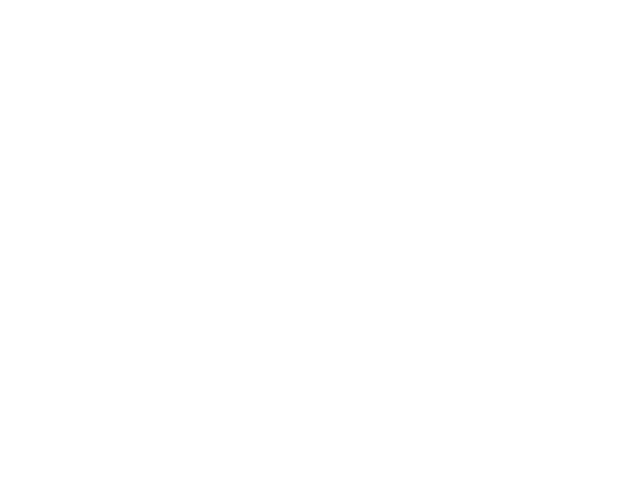

In [23]:
# electroners

#interacting
#Here we just compare on the different interaction strengths with noninteracting.

gamma_vec = [1e6]
plt.figure()
fig_num = 0
for gamma in gamma_vec:
    fig_num+=1
    hbar = 1   # Plancks constant
    m = 1      # electron mass
    L = 1      # Length of potential well
    xmin=-0.1  # minimum x-coordinate
    xmax=L+0.1 # maximum x-coordinate
    Vinf = 1e9 # value of (external) potential outside the well

    #gamma = 1e5  # Scaling of electron-electron interaction [ we use 1/|x-x'| --> V_delta*delta(x-x') ]

    mixer = 0.5
    dx = 0.001 # discretization in x


    x=np.arange(xmin,xmax,dx)
    nx = len(x)
    vext=0*x  # External potential
    n1=np.where(x<0)
    n2=np.where(x>L)
    vext[n1]=Vinf
    vext[n2]=Vinf
    #vext[n3]=Vinf
    Vext=np.diag(vext) #External potential as a matrix (operator) # makes the value into diagonal matrix.
    #plt.plot(x, vext)
    # 

    T=np.eye(nx) # Kinetic energy operator
    # print(T)
    for i in range(nx-1):
        T[i,i+1]=-0.5
        T[i+1,i]=-0.5
    T = T/(dx**2)*hbar**2/m
    # print(T)

    H = T + Vext   # Non-interacting Hamiltonian as matrix
    # print(H)

    En,Psi0 =LA.eigh(H,eigvals=(0,8))

    count = 1
    psi_diff = 100
    tol = 1e-3  # convergence criterion for the difference in wave functions
    #plt.plot(x, Psi0[:,0])
    
    psi1 = Psi0[:,0]
    psi2 = Psi0[:,1]

    count=1
    psi_diff = 100
    tol= 1e-6
    while (count<1000) and (psi_diff>tol):
        n1 = abs(psi1**2)
        n2 = abs(psi2**2) #probability function.

        # Setup effective potential for electron '1' and '2'
        v1 = n2*gamma     
        V1 = np.diag(v1) #effective potential is the other function

        v2 = n1*gamma  
        V2 = np.diag(v2)

        n12 = psi1*psi2 #We miss the nonlocal potential of the particle
        n21 = psi2*psi1 #

        #interaction from hartree fock equations
        v12 = n12*gamma
        V12 = np.diag(v12)
        v21 = n21*gamma
        V21 = np.diag(v21)

        # New hamiltonians for '1' and '2' # makes new hamiltonians
        H1 = T+Vext+V1 - V12
        H2 = T+Vext+V2 - V21

        e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
        e2,Psi2 = LA.eigh(H2,eigvals=(0,5))
        e1=e1[0]
        psi1_new=Psi1[:,0] # taking ground state.
        e2=e2[0]
        psi2_new=Psi2[:,0]

        psi_diff1 = sum(abs(abs(psi1)-abs(psi1_new))) # checing convergence by basically that it does not change to drastically
        psi_diff2 = sum(abs(abs(psi2)-abs(psi2_new)))
        psi_diff = max(psi_diff1,psi_diff2)
        count = count+1    

        psi1 = psi1*(1-mixer) + psi1_new*mixer # makes new wavefunctions as a mix of the ol plus the new.
        psi2 = psi2*(1-mixer) + psi2_new*mixer
        psi1 = psi1/norm(psi1) # normalizing
        psi2 = psi2/norm(psi2)
    print(f'converged after {count} steps!')
    plt.subplot(1, len(gamma), fig_num)
    plt.plot(psi1,'r',psi2,'g')
    plt.title(f'$\gamma$ = {gamma}')


In [ ]:
# from gpaw import GPAW
# from ase.build import bulk
# structure = bulk('Ag')
# calc = GPAW()
# structure.set_calculator(calc)
# structure.get_potential_energy()


In [ ]:
# view(structure, viewer='ngl')
# from ase.visualize import view
# view(structure, viewer='x3d')

# 3 elec

%matplotlib widget

%matplotlib widget
import numpy as np
from scipy import linalg as LA
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [24]:
import numpy as np
from scipy import linalg as LA
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from ase.build import bulk
from gpaw import GPAW

In [25]:
%matplotlib widget

<ipython-input-26-5717c9f9aae4>:31: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  En,Psi0 =LA.eigh(H,eigvals=(0,8))
<ipython-input-26-5717c9f9aae4>:59: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
<ipython-input-26-5717c9f9aae4>:60: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e2,Psi2 = LA.eigh(H2,eigvals=(0,5))
<ipython-input-26-5717c9f9aae4>:61: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  e3,Psi3 = LA.eigh(H3,eigvals=(0,5))


converged after 119 steps!


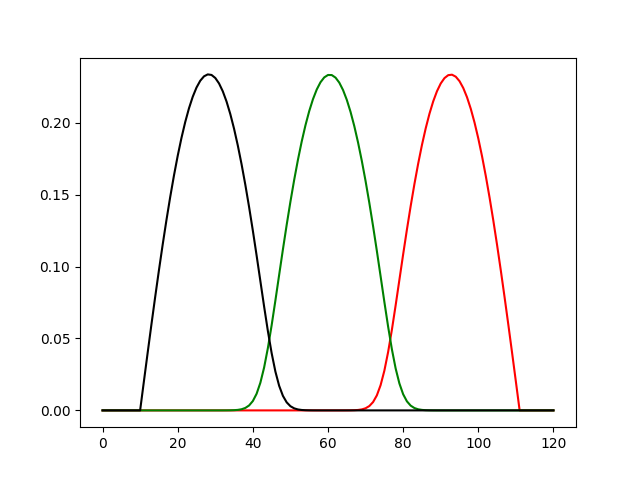

In [26]:
hbar = 1   # Plancks constant
m = 1      # electron mass
L = 1  # Length of potential well
xmin=-0.1  # minimum x-coordinate
xmax=L+0.1 # maximum x-coordinate
Vinf = 1e9 # value of (external) potential outside the well

gamma = 1e5  # Scaling of electron-electron interaction [ we use 1/|x-x'| --> V_delta*delta(x-x') ]

mixer = 0.5
dx = 0.01 # discretization in x

x=np.arange(xmin,xmax,dx)
nx = len(x)
vext=0*x  # External potential
n1=np.where(x<0)
n2=np.where(x>L)
vext[n1]=Vinf
vext[n2]=Vinf
Vext=np.diag(vext) #External potential as a matrix (operator) # makes the value into diagonal matrix.
#plt.plot(x, vext)
# 
T=np.eye(nx) # Kinetic energy operator
# print(T)
for i in range(nx-1):
    T[i,i+1]=-0.5
    T[i+1,i]=-0.5
T = T/(dx**2)*hbar**2/m
# print(T)
H = T + Vext   # Non-interacting Hamiltonian as matrix
En,Psi0 =LA.eigh(H,eigvals=(0,8))
# print(H)
psi1 = Psi0[:,0]
psi2 = Psi0[:,8]
psi3 = Psi0[:,3]

count=1
psi_diff = 100
tol= 1e-3
while (count<1000) and (psi_diff>tol):
    n1 = abs(psi1**2)
    n2 = abs(psi2**2) #probability function.
    n3 = abs(psi3**2)
    # Setup effective potential for electron '1' and '2'
    v1 = n2*gamma + n3*gamma     
    V1 = np.diag(v1) #effective potential is the other function

    v2 = n1*gamma + n3*gamma
    V2 = np.diag(v2)

    v3 = n1*gamma + n2*gamma
    V3 = np.diag(v3)

    # New hamiltonians for '1' and '2' # makes new hamiltonians
    H1 = T+Vext+V1
    H2 = T+Vext+V2
    H3 = T+Vext+V3

    e1,Psi1 = LA.eigh(H1,eigvals=(0,5)) # getting first 6 eigenvals
    e2,Psi2 = LA.eigh(H2,eigvals=(0,5))
    e3,Psi3 = LA.eigh(H3,eigvals=(0,5))
    e1=e1[0]
    psi1_new=Psi1[:,0] # taking ground state.
    e2=e2[0]
    psi2_new=Psi2[:,0]

    e3=e3[0]
    psi3_new=Psi3[:,0]

    psi_diff1 = sum(abs(abs(psi1)-abs(psi1_new))) # checing convergence by basically that it does not change to drastically
    psi_diff2 = sum(abs(abs(psi2)-abs(psi2_new)))
    psi_diff3 = sum(abs(abs(psi3)-abs(psi3_new)))
    psi_diff = max(psi_diff1,psi_diff2,psi_diff3)
    count = count+1    

    psi1 = psi1*(1-mixer) + psi1_new*mixer # makes new wavefunctions as a mix of the ol plus the new.
    psi2 = psi2*(1-mixer) + psi2_new*mixer
    psi3 = psi3*(1-mixer) + psi3_new*mixer
    psi1 = psi1/norm(psi1) # normalizing
    psi2 = psi2/norm(psi2)
    psi3 = psi3/norm(psi3)
print(f'converged after {count} steps!')
plt.figure()
plt.plot(psi1,'r',psi2,'g', psi3, 'k')
